# **一篇中文的Kaggle房价预测入门**

## **首先载入数据，数据的目录可以点右上角Commit&Run右边的小箭头查看**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns',None) # 显示所有列

data_train = pd.read_csv('./data/train.csv')
data_test = pd.read_csv('./data/test.csv')

train_ID = data_train['Id']
test_ID = data_test['Id']

data_train.drop(['Id'], axis=1, inplace=True)
data_test.drop(['Id'], axis=1, inplace=True)

data_train.head(10) # 打印头10条数据

ModuleNotFoundError: No module named 'matplotlib.pylot'

## **好了，我们看到数据了，接下来对数据进行分析处理**

### 首先看看数据中用于预测的特征有哪些

In [3]:
print(data_train.columns)
print("特征总数：", data_train.columns.size)

NameError: name 'data_train' is not defined

### 用于预测的数据中有79个特征（除去Id和SalePrice），而这些特征中经过一个房奴的分(cai)析(ce)得出对于买房最需要考虑的四个特征：
* OverallQual（总体质量）
* YearBuilt（修建年份）
* TotalBsmtSF（地下室总面积）
* GrLivArea（地上居住面积）

### 接下来进行一一画图分析它们和房价SalePrice间的关系

In [4]:
def plot_relation_to_price(data, fea):
    plt.scatter(data[fea], data['SalePrice'])
    plt.ylabel('SalePrice', fontsize=13)
    plt.xlabel(fea, fontsize=13)

plt.figure(figsize=(20,10))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(2,2,1)
plot_relation_to_price(data_train, 'OverallQual')
plt.subplot(2,2,2)
plot_relation_to_price(data_train, 'YearBuilt')
plt.subplot(2,2,3)
plot_relation_to_price(data_train, 'TotalBsmtSF')
plt.subplot(2,2,4)
plot_relation_to_price(data_train, 'GrLivArea')
plt.show()

NameError: name 'plt' is not defined

### 可以看出 
* OverallQual 和 SalePrice 分布趋势相同。
* YearBuilt 和 SalePrice 之间的关系没有很强的趋势性，但是可以看出建筑时间较短的房屋价格更高。
* GrLivArea 和 SalePrice 关系很密切，并且基本呈线性关系。
* TotalBsmtSF 和 SalePrice 关系也很密切，从图中可以看出基本呈指数分布，但从最左侧的点可以看出特定情况下 TotalBsmtSF 对 SalePrice 没有产生影响。

### 好的，我们只分析了四个特征，还有许多其它特征我们也应该分析分析，是不是想想头皮发麻？

### 上面的分(cai)析(ce)毫无根据，接下来，让我们看看如何利用相关系数矩阵真正找出和预测SalePrice相关的特征，以及如何筛选特征
### 首先计算相关性并画出相关性矩阵：

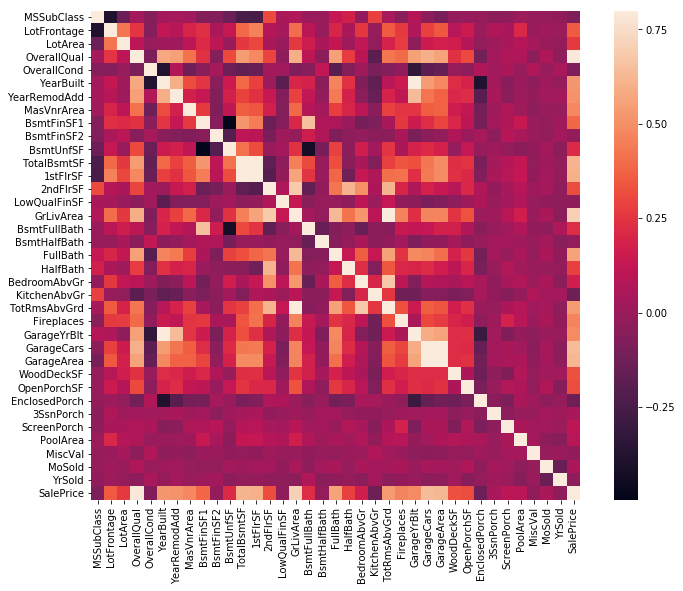

In [4]:
corrmat = data_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

### 可以看到两条边上SalePrice 的相关性，之前分析的OverallQual, GrLivArea和TotalBsmtSF等地方发白，说明相关性很强。另外看到的是对角线上两个明显的白色方块，第一个是 TotalBsmtSF 和 1stFlrSF 相关系数，第二个是 Garage[\*] 之间的相关系数，都显示了这些变量之间很强的相关性，这些变量可能包含了相同的信息。下面将这些特征拎出来重点分析：

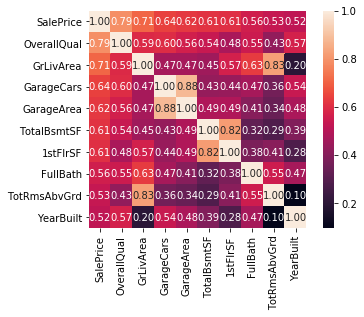

In [5]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index # 选出和SalePrice相关系数最大的10个特征（包含SalePrice）
cm = np.corrcoef(data_train[cols].values.T)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': k}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### 从图中可以看出：

* OverallQual，GrLivArea 以及 TotalBsmtSF 与 SalePrice 有很强的相关性。
* GarageCars 和 GarageArea 也和SalePrice相关性很强，但是它们之间的相关性非常强，所以我们只需要其中的一个。这里我们选择了 GarageCars，因为它与 SalePrice 的相关性更高一些。
* TotalBsmtSF 和 1stFloor 与上述情况相同，我们选择 TotalBsmtSF。
* FullBath 和其它特征相关性不强，直接选取。
* TotRmsAbvGrd 和 GrLivArea 也是变量中的双胞胎，之前已经选择了GrLivArea了，TotRmsAbvGrd不必考虑。
* YearBuilt 和 SalePrice 相关性似乎不强。

### 总结一下，我们筛选出了几个特征OverallQual、GrLivArea、GarageCars、TotalBsmtSF、FullBath、YearBuilt，接下来看看它们和SalePrice间的关系

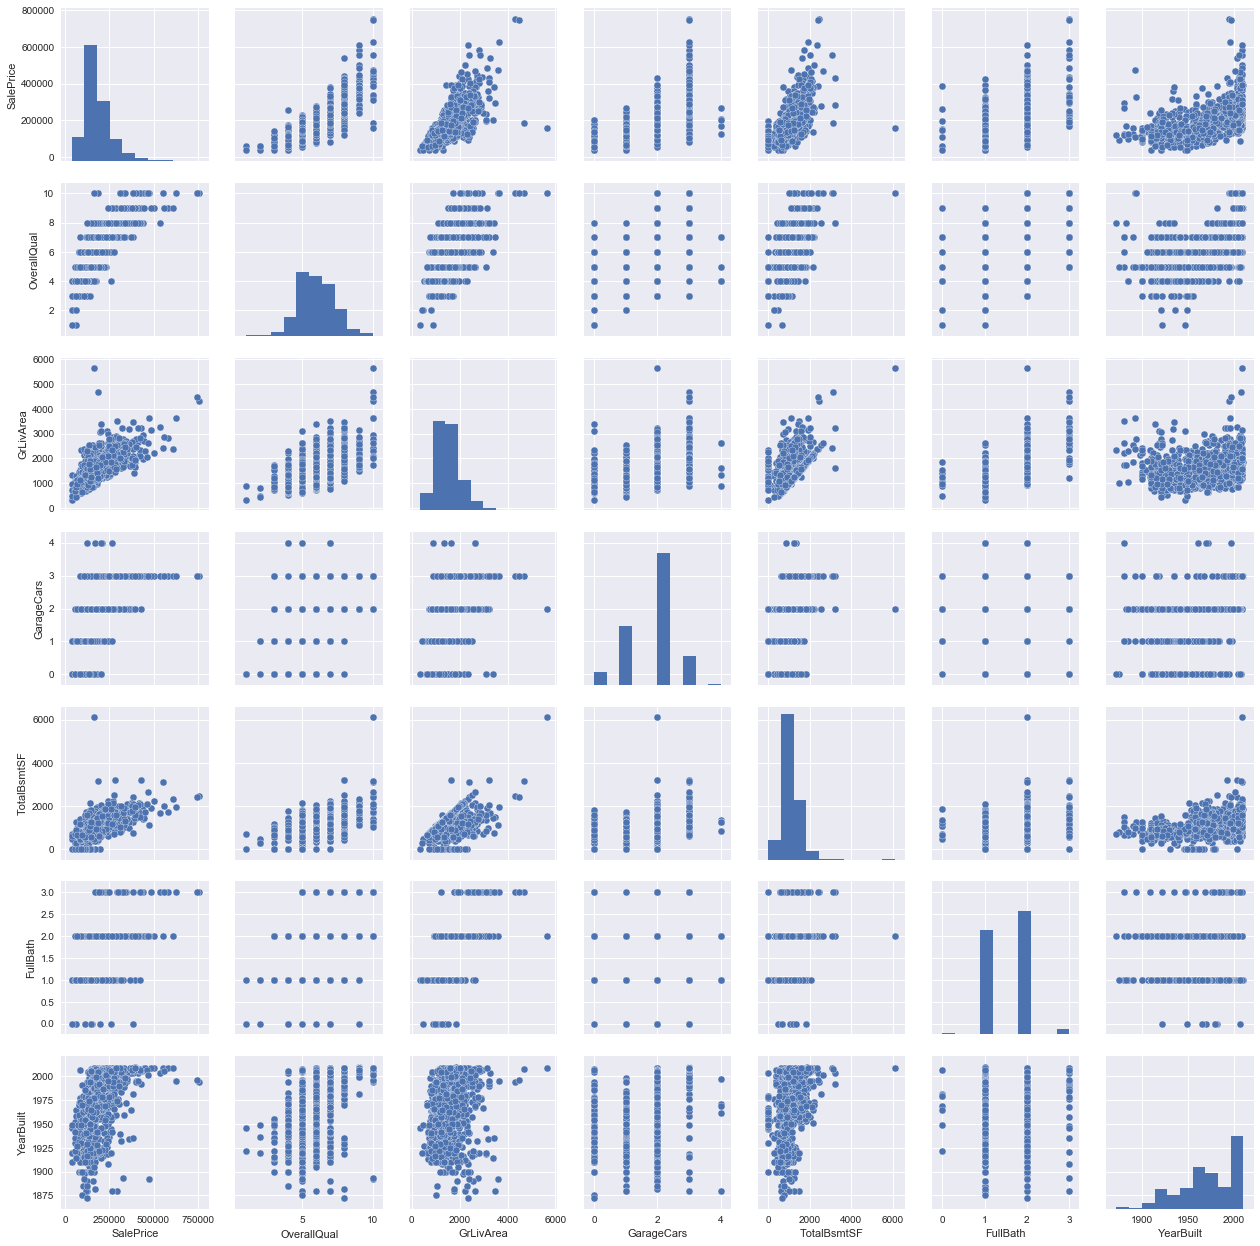

In [6]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea','GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(data_train[cols], size = 2.5)
plt.show();

### 根据上面这些图应该可以将其中有特点的逐一进行分析处理。

### 比如在上面的几个图中有一些明显的离群点，我们需要将它们删除：

In [7]:
useless_grlivarea_rows = data_train[(data_train['GrLivArea'] >4000) & (data_train['SalePrice']<300000)].index
useless_totalbsmtsf_rows = data_train[(data_train['TotalBsmtSF'] >6000)].index
useless_rows = useless_grlivarea_rows.union(useless_totalbsmtsf_rows)
data_train.drop(useless_rows,axis=0,inplace=True)

### 因为提供了测试数据，为了更好的清理数据，我们将测试数据和训练数据合并起来：

In [8]:
data_all = pd.concat((data_train, data_test)).reset_index(drop=True)
data_all.drop(['SalePrice'], axis=1, inplace=True)

### 接下来看看数据缺失的问题，首先打印每个特征的空值数和空值率：

In [9]:
def calc_null(data):
    total= data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'])
    print(missing_data.head(20))
    
calc_null(data_all)

              Total   Percent
PoolQC         2908  0.996915
MiscFeature    2812  0.964004
Alley          2719  0.932122
Fence          2346  0.804251
FireplaceQu    1420  0.486802
LotFrontage     486  0.166610
GarageFinish    159  0.054508
GarageQual      159  0.054508
GarageYrBlt     159  0.054508
GarageCond      159  0.054508
GarageType      157  0.053822
BsmtCond         82  0.028111
BsmtExposure     82  0.028111
BsmtQual         81  0.027768
BsmtFinType2     80  0.027425
BsmtFinType1     79  0.027083
MasVnrType       24  0.008228
MasVnrArea       23  0.007885
MSZoning          4  0.001371
BsmtHalfBath      2  0.000686


### 根据上述统计分析如下：
* 当超过 15% 的数据都缺失的时候，我们应该删掉相关特征且假设该变量并不存在。根据这一条，一系列特征都应该删掉，例如 PoolQC，MiscFeature，Alley 等等，这些特征都不是很重要，因为他们基本都不是我们买房子时会考虑的因素。
* Garage[\*] 特征的缺失数据量都相同，由于我们已经有了 GarageCars ，所以删除这些特征。
* 对于 MasVnrArea 和 MasVnrType，我们可以认为这些因素并不重要。除此之外，他们和 YearBuilt 以及 OverallQual 都有很强的关联性，而这两个变量我们已经考虑过了。所以删除 MasVnrArea 和 MasVnrType 并不会太多的丢失信息。
* Bsmt[\*]特征分析同上，我们已经有了TotalBsmtSF。
* 最后，由于 Electrical 中只有一个损失的观察值，所以我们删除这个观察值，但是保留这一变量。

### 对于需要保留的特征的缺失数据，按情况填充默认值（一般情况按均值填充），注意填充时测试数据应该和训练数据一致，接下来一一处理：

* ### PoolQC : 数据为空表示“没有游泳池”，这很容易理解，一般99%的房子 都没有游泳池。

In [10]:
data_all["PoolQC"] = data_all["PoolQC"].fillna("None")

* ### MiscFeature : 空值表示没有杂项特征

In [11]:
data_all["MiscFeature"] = data_all["MiscFeature"].fillna("None")

* ### Alley : 空值表示没有小巷入口

In [12]:
data_all["Alley"] = data_all["Alley"].fillna("None")

* ### Fence : 空值表示没有栅栏

In [13]:
data_all["Fence"] = data_all["Fence"].fillna("None")

* ### FireplaceQu : 空值表示没有壁炉

In [14]:
data_all["FireplaceQu"] = data_all["FireplaceQu"].fillna("None")

* ### LotFrontage : 因为每条街邻居间房子的临街大小差不多，所以我们用邻居房子的平均临街大小来填充。

In [15]:
data_all["LotFrontage"] = data_all.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

* ### GarageCond, GarageType, GarageFinish, GarageQual  : 用None填充空值，，代表没有车

In [16]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    data_all[col] = data_all[col].fillna('None')

* ### GarageYrBlt,GarageCars,GarageArea: 用0填充空值，代表没有车

In [17]:
for col in ('GarageYrBlt', 'GarageCars', 'GarageArea'):
    data_all[col] = data_all[col].fillna(0)

* ### BsmtFinSF1, BsmtFinSF2, BsmtFullBath,BsmtHalfBath,TotalBsmtSF,BsmtUnfSF: 用0填充空值，代表没有地下室

In [18]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF', 'BsmtUnfSF'):
    data_all[col] = data_all[col].fillna(0)

* ### BsmtExposure, BsmtCond, BsmtQual,BsmtFinType1,BsmtFinType2 : 用None填充空值，代表没有地下室

In [19]:
for col in ('BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType1', 'BsmtFinType2'):
    data_all[col] = data_all[col].fillna('None')

* ### MasVnrArea and MasVnrType : 空值表示房子没有墙体外表。

In [20]:
data_all["MasVnrType"] = data_all["MasVnrType"].fillna("None")
data_all["MasVnrArea"] = data_all["MasVnrArea"].fillna(0)

* ### MSZoning (The general zoning classification) : 只有4条空值，用频率最高的值代替。

In [21]:
data_all['MSZoning'] = data_all['MSZoning'].fillna(data_all['MSZoning'].mode()[0])

* ### Utilities : 这个特征没用，删除掉。

In [22]:
if data_all.columns.contains('Utilities'):
    data_all = data_all.drop(['Utilities'], axis=1)

* ### Electrical : 只有一条空值，用频率最高的值代替。其它几个同样处理。

In [23]:
data_all['Electrical'] = data_all['Electrical'].fillna(data_all['Electrical'].mode()[0])
data_all['Functional'] = data_all['Functional'].fillna(data_all['Functional'].mode()[0])
data_all['KitchenQual'] = data_all['KitchenQual'].fillna(data_all['KitchenQual'].mode()[0])
data_all['Exterior1st'] = data_all['Exterior1st'].fillna(data_all['Exterior1st'].mode()[0])
data_all['Exterior2nd'] = data_all['Exterior2nd'].fillna(data_all['Exterior2nd'].mode()[0])
data_all['SaleType'] = data_all['SaleType'].fillna(data_all['SaleType'].mode()[0])

### 最后来看看空值的个数

In [24]:
print(data_all.isnull().sum().sum())

0


### 应该没有空值了。

### 将一些实际是类型特征的数值特征做变换

In [25]:
# 建筑类型
data_all['MSSubClass'] = data_all['MSSubClass'].apply(str)
# 总体条件
data_all['OverallCond'] = data_all['OverallCond'].astype(str)
# 销售年份月份
data_all['YrSold'] = data_all['YrSold'].astype(str)
data_all['MoSold'] = data_all['MoSold'].astype(str)

### 将一些有特定值集的类型特征进行标签编码

In [26]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# 按列进行标签编码
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(data_all[c].values)) 
    data_all[c] = lbl.transform(list(data_all[c].values))
      
print('Shape all_data: {}'.format(data_all.shape))

Shape all_data: (2917, 78)


### 通过现有特征变换添加一些特征

In [27]:
def add_feats(X):
    X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
    X["UnitQual"] = X["OverallQual"] / X["TotalHouse"] 
    X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
    X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
    
    #X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
    return X

data_all = add_feats(data_all)

### 偏斜特征

In [28]:
skewed_feats = data_all.select_dtypes(exclude='object').apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)

,Skew
MiscVal,21.939672
PoolArea,17.688664
LotArea,13.109495
LowQualFinSF,12.084539
3SsnPorch,11.372080
LandSlope,4.973254
KitchenAbvGr,4.300550
BsmtFinSF2,4.144503
EnclosedPorch,4.002344
ScreenPorch,3.945101


In [29]:
skewness = skewness[abs(skewness) > 0.75]
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #data_all[feat] += 1
    data_all[feat] = boxcox1p(data_all[feat], lam)

### 将类型特征转换为独热码

In [30]:
data_all = pd.get_dummies(data_all)

### 特征处理完成，再来看看将要预测的SalePrice的分布

count      1458.000000
mean     180932.919067
std       79495.055285
min       34900.000000
25%      129925.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


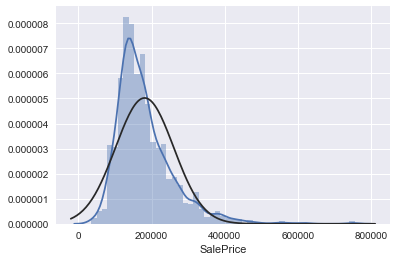

In [31]:
print(data_train.SalePrice.describe()) # 打印价格统计
sns.distplot(data_train.SalePrice, fit=norm) # 画价格分布直方图

### 从上图可以看出价格的分布偏离正态分布，我们可以使用对数函数log1p让它更像正态分布，**注意在最终预测后用指数函数expm1还原**

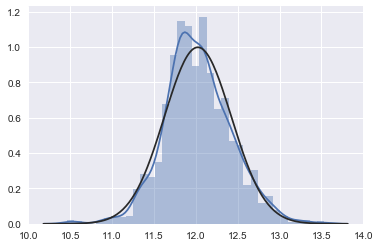

In [32]:
y_train = np.log1p(data_train.SalePrice.values)
sns.distplot(y_train, fit=norm) # 画价格分布直方图

### 数据处理完成，最后得到训练数据X_train和测试数据X_test

In [33]:
ntrain = data_train.iloc[:,0].size
print(ntrain)
X_train = data_all[:ntrain]
X_test = data_all[ntrain:]

1458


## 建模
### 导入库

In [34]:
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

### 定义交叉验证策略

In [35]:
n_folds = 5 # 交叉验证折数

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

### 定义网格搜索类

In [36]:
class grid():
    def __init__(self,model):
        self.model = model
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5,scoring='neg_mean_squared_error')
        grid_search.fit(X,y)
        print(grid_search.best_params_,np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

class random():
    def __init__(self,model):
        self.model = model
    def random_get(self,X,y,param_grid):
        random_search = RandomizedSearchCV(self.model,param_grid,random_state= 0,
                                           n_iter = 10,scoring='neg_mean_squared_error')
        random_search.fit(X,y)
        print(random_search.best_params_,np.sqrt(-random_search.best_score_))
        random_search.cv_results_['mean_test_score'] = np.sqrt(-random_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(random_search.cv_results_)[['params','mean_test_score','std_test_score']])

### 基础模型
* LASSO 回归

In [37]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
#grid(Lasso()).grid_get(X_train,y_train,{'alpha':[0.01,0.001,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0009],'max_iter':[10000]})
#random(Lasso()).random_get(X_train,y_train,{'alpha':[0.01,0.001,0.0001,0.0002,0.0003,0.0004,0.0005,0.0006,0.0007,0.0009]})

* Elastic Net 回归

In [38]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
#grid(ElasticNet()).grid_get(X_train,y_train,{'alpha':[0.003, 0.004,0.005,0.006,0.0065],'l1_ratio':[0.6,0.7,0.8,0.9],'max_iter':[10000]})

* Kernel Ridge 回归

In [39]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

* Gradient Boosting 回归

In [40]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

* XGBoost

In [41]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

* LightGBM

In [42]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

### 基础模型得分

In [43]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1116 (0.0074)



In [44]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 0.1116 (0.0074)



In [45]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1155 (0.0076)



In [46]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1172 (0.0076)



In [47]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1172 (0.0071)



In [48]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1150 (0.0063)



### 堆叠模型
### 最简单的堆叠模型 : 平均基础模型

In [49]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

### 平均基础模型得分
### 这里我们堆叠4个模型 ENet, GBoost, KRR 和 lasso。 当然我们可以简单的堆叠更多模型。

In [50]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1088 (0.0076)



哇 ! 简单的堆叠模型就能够显著提高分数，这激励我们向前探索！

### 不那么简单的堆叠 : 添加一个元模型
在这种方法中，我们在平均基础模型上添加元模型，并使用这些基础模型的out-of-folds预测来训练我们的元模型。
训练过程如下：
1. 将整个训练集分成互不相交的两组(这里是train和holdout)
2. 使用train训练一些基础模型
3. 使用holdout测试这些基础模型
4. 使用3.中的预测（称之为out-of-folds预测）当做输入，真实标签作为输出，对更高层次的原模型进行训练

开始的三步是迭代完成的 。如果我们用5折堆叠，那么把训练数据分成5份，然后做5次迭代。在每次迭代中我们在4份数据（train）上训练其中一个基础模型然后在剩下的1份数据（holdout）上进行预测。

所以我们能够确定当5次迭代后全部数据已经进行了out-of-folds预测，然后我们会用它们在第四步中对元模型进行训练。

在预测的部分，我们将所有基础模型在测试数据上的预测进行平均，将它们作为meta-features，由元模型完成最终预测。.

![](http://i.imgur.com/QBuDOjs.jpg)

![](http://5047-presscdn.pagely.netdna-cdn.com/wp-content/uploads/2017/06/image5.gif)

在上面的动画中，基础模型是0、1、2，元模型为3。全部训练数据为A+B(真实标签y已知)，A为train部分而B为holdout部分，测试数据为C。

B1 (holdout部分的预测)是用来训练元模型3的新特征，C1 (对测试数据的预测) 是在最终预测中的meta-feature。

In [51]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

### 堆叠平均模型得分

要使两种方法具有可比性 (使用同样数量的模型) , 我们还是平均 Enet KRR 和 Gboost, 然后使用 lasso 作为元模型。

In [52]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

#score = rmsle_cv(stacked_averaged_models)
#print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

## 集成 StackedRegressor, XGBoost 和 LightGBM
我们将 XGBoost 和 LightGBM 加入之前定义的StackedRegressor中。首先定义一个rmsle评估函数：

In [53]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## 最终的训练和预测
* StackedRegressor

In [54]:
stacked_averaged_models.fit(X_train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values))
print(rmsle(y_train, stacked_train_pred))

0.07778226956162536


* XGBoost

In [55]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(X_test))
print(rmsle(y_train, xgb_train_pred))

0.07770790908820192


* LightGBM:

In [56]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(X_test.values))
print(rmsle(y_train, lgb_train_pred))

0.07058866790936608


### 平均上述结果

In [57]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07461316289407545


### 集成模型的预测

In [58]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

## 提交结果

In [59]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission_x.csv',index=False)

In [60]:
ensemble

array([121702.18551073, 160180.13627106, 186197.62425542, ...,
       166790.36391317, 116137.16309448, 220246.34131611])